In [41]:
library('RODBC')
library('quantmod')
library('PerformanceAnalytics')
library('colorspace')
library('extrafont')
library('lubridate')
source("/usr/common/config.R")
lcon <- odbcDriverConnect(sprintf("Driver={SQL Server};Server=%s;Database=%s;Uid=%s;Pwd=%s;", ldbserver, ldbname, ldbuser, ldbpassword), case = "nochange", believeNRows = TRUE)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [37]:
#get the listing dates of all 'EQ' and 'BE' series stocks
allStarts<-sqlQuery(lcon, "select symbol, min(time_stamp), max(time_stamp) from px_history 
                            where (series='eq' or series='be')
                            and time_stamp >= '2010-01-01' and time_stamp < '2017-06-01'
                            group by symbol")

allStarts[,2]<-as.Date(allStarts[,2])
allStarts[,3]<-as.Date(allStarts[,3])
#remove delisted
allStarts<-allStarts[allStarts[,3] == max(allStarts[,3]),]

#print(allStarts)

In [38]:
cumRets<-data.frame(SYMBOL="", LDATE="", D0=0.0, D5=0.0, D10=0.0, D20=0.0, D50=0.0, D100=0.0, stringsAsFactors = F)

for(i in 1:length(allStarts[,1])){
    sym<-toString(allStarts[i,1])
    
    retSeries<-sqlQuery(lcon, sprintf("select time_stamp, daily_return from RETURN_SERIES_ALL 
                                        where symbol='%s' and time_stamp >='%s'", sym, allStarts[i,2]))
    
    retXts<-xts(retSeries[,2], as.Date(retSeries[,1]))
    
    ###! there should be a better way to do this !###
    d5<-ifelse(length(retXts) >= 6, Return.cumulative(retXts[2:6]), NA)
    d10<-ifelse(length(retXts) >= 11, Return.cumulative(retXts[2:11]), NA)
    d20<-ifelse(length(retXts) >= 21, Return.cumulative(retXts[2:21]), NA)
    d50<-ifelse(length(retXts) >= 51, Return.cumulative(retXts[2:51]), NA)
    d100<-ifelse(length(retXts) >= 101, Return.cumulative(retXts[2:101]), NA)
    
    cumRets<-rbind(cumRets, c(sym, toString(allStarts[i,2]), retXts[1]*100, d5*100, d10*100, d20*100, d50*100, d100*100))
}

cumRets<-cumRets[-1,]
#print(cumRets)

Warning message:
“closing unused RODBC handle 2”

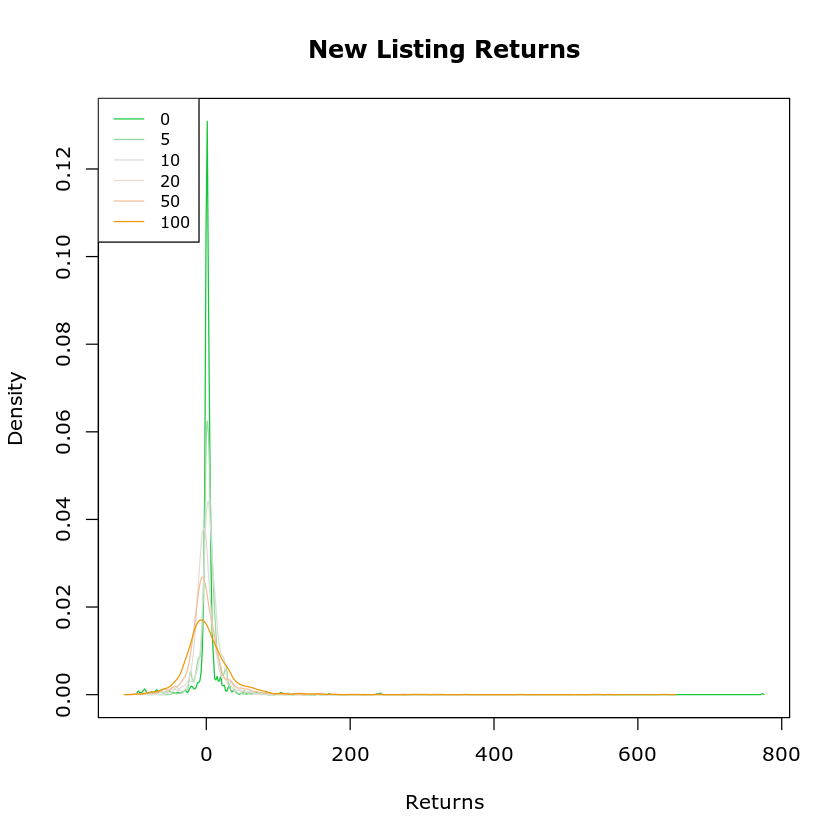

In [39]:
uLimit<-1000 #if cumulative returns exceed upper/lower limit, ignore them
lLimit<--1000

cumRets$D0<-as.numeric(cumRets$D0)
cumRets$D5<-as.numeric(cumRets$D5)
cumRets$D10<-as.numeric(cumRets$D10)
cumRets$D20<-as.numeric(cumRets$D20)
cumRets$D50<-as.numeric(cumRets$D50)
cumRets$D100<-as.numeric(cumRets$D100)

d0<-density(cumRets[cumRets$D0 < uLimit & cumRets$D0 > lLimit,]$D0, na.rm=T)
d5<-density(cumRets[cumRets$D5 < uLimit & cumRets$D5 > lLimit,]$D5, na.rm=T)
d10<-density(cumRets[cumRets$D10 < uLimit & cumRets$D10 > lLimit,]$D10, na.rm=T)
d20<-density(cumRets[cumRets$D20 < uLimit & cumRets$D20 > lLimit,]$D20, na.rm=T)
d50<-density(cumRets[cumRets$D50 < uLimit & cumRets$D50 > lLimit,]$D50, na.rm=T)
d100<-density(cumRets[cumRets$D100 < uLimit & cumRets$D100 > lLimit,]$D100, na.rm=T)

lineColors<-diverge_hcl(6, h = c(130, 43), c = 100, l = c(70, 90))

par(family='Verdana')
plot(range(d0$x, d5$x, d10$x, d20$x, d50$x, d100$x), range(d0$y, d5$y, d10$y, d20$y, d50$y, d100$y), type = "n", 
     ylab = "Density", xlab="Returns", main="New Listing Returns")

lines(d0, col=lineColors[1])
lines(d5, col=lineColors[2])
lines(d10, col=lineColors[3])
lines(d20, col=lineColors[4])
lines(d50, col=lineColors[5])
lines(d100, col=lineColors[6])
par(cex=0.8)
legend('topleft', legend=c('0', '5', '10', '20', '50', '100'), lty=1, col=lineColors)



In [68]:
cumRets$LDATE<-as.Date(cumRets$LDATE)
ctemp<-cumRets[!is.na(cumRets$D10),]

ctemp$D0<-round(ctemp$D0, 2)
ctemp$D5<-round(ctemp$D5, 2)
ctemp$D10<-round(ctemp$D10, 2)
ctemp$D20<-round(ctemp$D20, 2)
ctemp$D50<-round(ctemp$D50, 2)
ctemp$D100<-round(ctemp$D100, 2)

c2010<-ctemp[year(ctemp$LDATE) == 2010 & ctemp$D10 > lLimit & ctemp$D10 < uLimit,]
c2011<-ctemp[year(ctemp$LDATE) == 2011 & ctemp$D10 > lLimit & ctemp$D10 < uLimit,]
c2012<-ctemp[year(ctemp$LDATE) == 2012 & ctemp$D10 > lLimit & ctemp$D10 < uLimit,]
c2013<-ctemp[year(ctemp$LDATE) == 2013 & ctemp$D10 > lLimit & ctemp$D10 < uLimit,]
c2014<-ctemp[year(ctemp$LDATE) == 2014 & ctemp$D10 > lLimit & ctemp$D10 < uLimit,]
c2015<-ctemp[year(ctemp$LDATE) == 2015 & ctemp$D10 > lLimit & ctemp$D10 < uLimit,]
c2016<-ctemp[year(ctemp$LDATE) == 2016 & ctemp$D10 > lLimit & ctemp$D10 < uLimit,]
c2017<-ctemp[year(ctemp$LDATE) == 2017 & ctemp$D10 > lLimit & ctemp$D10 < uLimit,]

print("ALL")
summary(ctemp$D10)
print("c2010")
summary(c2010$D10)
print("c2011")
summary(c2011$D10)
print("c2012")
summary(c2012$D10)
print("c2013")
summary(c2013$D10)
print("c2014")
summary(c2014$D10)
print("c2015")
summary(c2015$D10)
print("c2016")
summary(c2016$D10)
print("c2017")
summary(c2017$D10)


[1] "ALL"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -98.55   -1.71    3.88    5.73   11.69  454.76 

[1] "c2010"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-44.9600   0.2325   4.9850   6.9057  12.0250 110.3700 

[1] "c2011"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-56.570 -22.025  -5.450  -8.267   1.725  58.820 

[1] "c2012"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-53.0800  -7.4600  -0.9200   0.6516   7.2000  36.5000 

[1] "c2013"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-50.100 -17.565  -2.100  -3.555   5.992  72.900 

[1] "c2014"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-39.540  -2.618   3.955   6.538  14.258  61.910 

[1] "c2015"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-48.2500  -9.3800  -1.6100  -0.3907   3.4300 120.5100 

[1] "c2016"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -98.55  -11.14    1.88   11.71   18.17  454.76 

[1] "c2017"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-15.910  -2.482   2.285  11.174  18.128 100.000 

In [69]:
c2010[order(c2010$D10, decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
715,BEARDSELL,2010-01-08,105.00,91.83,110.37,66.59,47.81,29.27
1212,TGBHOTELS,2010-01-04,2.30,54.79,78.77,52.45,45.30,63.50
340,HINDCOPPER,2010-01-08,16.03,17.86,66.14,46.61,42.82,29.75
1384,ORIENTLTD,2010-03-03,125.08,72.44,63.70,61.67,48.79,65.66
1255,FEL,2010-01-04,4.99,27.54,62.36,106.47,89.29,22.65
1530,FELDVR,2010-01-04,4.96,27.40,61.83,84.00,116.14,70.14
789,CONSOFINVT,2010-01-04,3.18,18.25,54.93,27.51,2.40,4.20
771,RANEENGINE,2010-01-04,-3.22,40.14,54.46,53.88,67.45,109.39
580,SORILINFRA,2010-01-04,0.50,27.86,52.74,19.40,10.78,-6.63
1460,ZEELEARN,2010-12-20,-93.37,27.99,50.64,11.20,18.83,13.99


In [70]:
c2011[order(c2011$D10, decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
130,ONELIFECAP,2011-10-17,32.68,35.97,58.82,89.89,59.23,125.32
268,RUSHIL,2011-07-07,65.97,31.13,42.13,-0.42,51.62,28.45
185,RAIREKMOH,2011-07-13,-5.00,39.61,38.63,-26.90,-61.60,-58.25
671,FLEXITUFF,2011-10-19,6.81,29.15,37.48,55.39,56.48,52.34
841,HFCL,2011-03-09,6.38,-9.15,33.93,61.97,68.72,61.45
398,DHUNINV,2011-03-18,-63.90,11.57,24.21,43.93,15.00,17.72
1304,SEINV,2011-10-17,-4.55,7.52,23.03,61.26,102.54,207.65
1197,RASOYPR,2011-12-12,4.40,1.75,20.00,24.56,22.63,-20.70
78,BANARBEADS,2011-12-29,237.28,15.61,19.30,15.26,7.02,-8.95
1233,LOVABLE,2011-03-24,21.73,-1.68,17.03,30.90,30.21,73.20


In [71]:
c2012[order(c2012$D10, decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
1482,SPECIALITY,2012-05-30,6.40,13.35,36.50,33.99,9.68,12.73
798,SUNCLAYLTD,2012-10-23,31.22,27.12,32.18,31.27,51.81,33.72
1317,RTNINFRA,2012-07-30,-93.32,25.00,32.14,-4.76,41.09,51.50
502,NAGAROIL,2012-03-28,-70.28,32.14,25.00,11.43,-19.29,-19.29
183,SCHNEIDER,2012-03-20,-68.69,8.74,23.97,51.34,29.15,30.69
209,MTEDUCARE,2012-04-12,12.94,20.25,21.97,3.32,3.93,5.37
1124,PROZONINTU,2012-09-12,-30.35,4.00,21.89,18.53,49.26,42.10
338,CINELINE,2012-06-13,-54.50,-15.28,21.53,20.14,1.74,18.06
629,PCJEWELLER,2012-12-27,10.52,23.02,11.33,3.18,-14.98,-22.72
413,INFRATEL,2012-12-28,-12.89,8.09,7.20,8.69,1.07,-11.32


In [72]:
c2013[order(c2013$D10, decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
735,NIBL,2013-04-16,-88.20,25.23,72.90,78.50,45.79,63.55
289,PILITA,2013-10-09,-16.13,42.31,36.54,57.69,73.08,100.00
101,FCONSUMER,2013-07-04,-29.19,8.40,16.03,5.34,-7.63,-25.66
542,NAKODA,2013-03-14,-0.84,5.08,8.05,14.83,0.42,-13.16
796,NIFTYIWIN,2013-04-05,0.91,4.66,6.23,6.20,7.47,1.05
344,REPCOHOME,2013-04-01,-5.93,7.48,6.21,6.77,30.87,44.47
1318,JUSTDIAL,2013-06-05,15.54,3.86,6.03,3.80,7.95,71.55
1152,GSCLCEMENT,2013-05-15,112.50,25.41,5.88,-12.47,-27.45,-26.46
803,NIF100IWIN,2013-08-27,0.31,1.55,2.82,3.42,4.35,-1.38
221,LYPSAGEMS,2013-11-05,0.68,2.48,0.34,-0.47,-1.34,4.16


In [73]:
c2014[order(c2014$D10, decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
1403,NATHBIOGEN,2014-01-28,103.88,27.38,61.91,162.62,326.19,297.14
1389,CAPLIPOINT,2014-06-23,1.16,21.48,56.06,80.20,146.20,132.12
882,ARCOTECH,2014-04-16,0.86,8.89,38.54,46.23,74.83,109.94
407,WONDERLA,2014-05-09,26.24,8.17,22.75,34.89,45.56,82.34
1045,INTELLECT,2014-12-18,-70.69,10.04,22.35,75.87,66.31,50.17
127,RELDIVOPP,2014-05-22,0.63,8.51,19.43,22.29,11.43,27.14
713,8KMILES,2014-01-29,-2.91,18.81,16.98,13.52,6.76,84.09
743,SNOWMAN,2014-09-12,69.79,18.42,13.35,-1.38,34.90,5.20
1348,SHARDACROP,2014-09-23,48.04,12.92,11.28,13.60,11.58,16.48
672,GOCLCORP,2014-06-26,-2.22,12.77,9.01,6.31,5.50,-2.64


In [74]:
c2015[order(c2015$D10, decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
1250,ANANDAMRUB,2015-12-01,28.77,26.74,120.51,97.07,56.14,60.34
234,SATIN,2015-08-27,9.29,27.45,70.29,113.83,306.67,287.08
1418,APOLSINHOT,2015-02-16,31.23,27.61,62.04,103.27,43.06,29.40
421,BALKRISHNA,2015-07-28,9.95,60.68,60.05,57.63,58.13,74.54
1448,ADANITRANS,2015-07-31,-95.67,26.99,44.75,17.21,2.35,30.07
218,ZENTEC,2015-03-30,12.47,27.36,35.00,6.18,28.18,55.82
164,RAMASTEEL,2015-08-24,8.33,19.38,25.70,33.96,38.19,41.05
860,LYCOS,2015-05-08,5.00,15.17,25.40,35.98,16.58,-5.03
695,LFIC,2015-04-17,4.89,26.98,24.14,80.53,85.06,86.61
138,SPHEREGSL,2015-10-13,3.65,-1.71,24.10,28.48,32.86,19.33


In [75]:
c2016[order(c2016$D10, decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
1134,QUESS,2016-07-12,58.71,119.35,454.76,506.52,538.22,636.92
1037,SETF10GILT,2016-06-23,-19.46,67.70,163.87,-15.56,-83.00,-84.20
1543,ASPINWALL,2016-06-14,19.87,66.32,152.15,271.32,181.40,132.52
656,THYROCARE,2016-05-09,38.74,161.02,151.89,146.73,125.85,154.23
1026,ADVENZYMES,2016-08-01,31.48,164.68,145.98,153.14,242.97,236.67
258,SHRIPISTON,2016-06-09,25.00,80.86,130.80,275.87,559.84,436.55
1360,GROBTEA,2016-07-14,31.13,59.38,101.93,20.99,-7.64,-7.96
1038,NBIFIN,2016-12-07,25.00,27.59,62.78,165.04,1044.84,1399.97
491,KIOCL,2016-11-29,5.00,25.71,59.05,156.67,NA,NA
247,UJJIVAN,2016-05-10,10.26,29.59,50.96,109.90,144.24,175.94


In [76]:
c2017[order(c2017$D10, decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
868,SPCENET,2017-01-10,-65.52,50.00,100.00,220.00,50.00,NA
1007,WIPL,2017-04-18,-19.56,27.17,61.96,111.41,NA,NA
257,HISARMETAL,2017-01-05,9.96,21.43,51.57,25.96,79.44,72.47
1576,DOLLAR,2017-04-21,773.23,13.73,27.82,16.13,NA,NA
981,CORALFINAC,2017-03-29,-3.39,16.29,24.10,36.40,NA,NA
387,ARIHANTSUP,2017-03-28,-0.28,23.52,23.42,40.76,NA,NA
736,NRAIL,2017-04-05,1.43,22.06,18.86,20.08,NA,NA
1144,SHANKARA,2017-04-05,37.49,19.84,15.93,11.49,NA,NA
1100,AKSHARCHEM,2017-03-28,-0.61,13.06,13.50,13.30,NA,NA
1111,JITFINFRA,2017-02-27,-4.92,-14.31,9.14,46.29,28.22,NA
